## Look into the dataset

First we need to make sure that Python 3.8 is used in the notebook

In [16]:
import sys
sys.version

'3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]'

We take 4D data generated from the event level data provided.

In [17]:
import pandas as pd 
import numpy as np
import sklearn
data_path=r'C:\Users\prach\OneDrive\Documents\Projects\gsoc_cern-hsf\4d_data.csv'
df=pd.read_csv(data_path)
df_obj=df[[ "E", "pt", "eta", "phi"]]

In [18]:
def normalize(df):
    df['eta'] = df['eta']/5
    df['phi'] = df['phi']/3
    df['E'] = np.log10(df['E'])
    df['pt'] = np.log10(df['pt'])
    return df
df_obj=normalize(df_obj)

<ipython-input-18-f0aa099a7d0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eta'] = df['eta']/5
<ipython-input-18-f0aa099a7d0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['phi'] = df['phi']/3
<ipython-input-18-f0aa099a7d0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_obj, test_size=0.2, random_state=42, shuffle=True)

# To get an idea of the order of magnitude we are going to see in the plots we show the first elements 
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
              E        pt       eta       phi
1047   4.906713  4.700341 -0.209428 -0.590943
21728  6.347139  5.855345  0.359682 -1.025347
6561   5.997825  5.637058  0.294436 -0.623413
19860  5.372660  4.761313  0.416874  0.697643
10042  5.797168  5.707606 -0.130892  0.219345


Testing sample:
              E        pt       eta       phi
447    5.154570  4.361824 -0.502360  0.611330
15994  5.669887  5.194112  0.351552 -0.487810
14844  5.136172  4.816144 -0.273020  0.025235
134    5.028673  4.574284  0.341054 -0.929800
13119  6.243935  4.664594 -0.865906 -0.803610


The number of entries in the training data: 18128
The number of entries in the validation data: 4533


Now we plot the data using the matplotlib library.

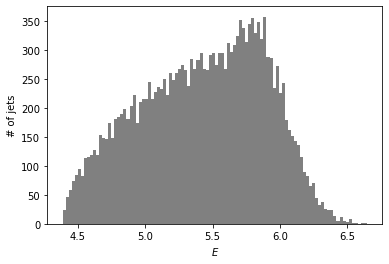

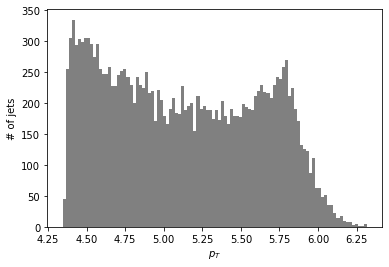

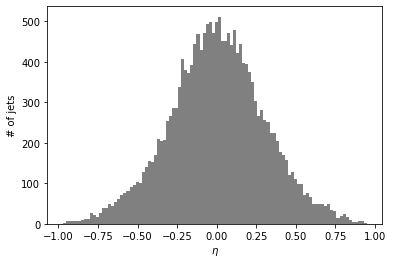

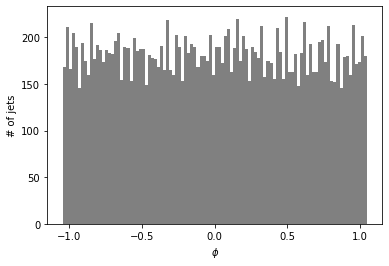

In [20]:
import matplotlib.pyplot as plt

#unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
#Note: Avoided mentioning units because units of E not known
variable_list = [r'$E$',r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E","pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    # plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('# of jets')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [22]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [23]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [24]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Training a new network

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.00831763744354248
Learning rate with the steepest gradient: 0.0020892962347716093


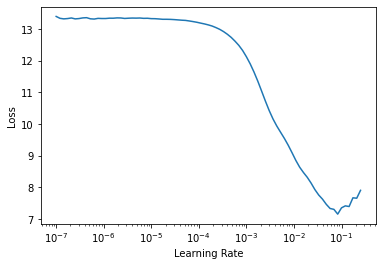

In [25]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [27]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100,lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 2.076446056365967, 0.4719425141811371, '00:01']
[0, 2.076446056365967, 0.4719425141811371, '00:01']
[1, 0.603672206401825, 0.23122328519821167, '00:01']
[1, 0.603672206401825, 0.23122328519821167, '00:01']
[2, 0.31370261311531067, 0.22735340893268585, '00:01']
[2, 0.31370261311531067, 0.22735340893268585, '00:01']
[3, 0.2473517805337906, 0.22718492150306702, '00:01']
[3, 0.2473517805337906, 0.22718492150306702, '00:01']
[4, 0.1930607110261917, 0.14199934899806976, '00:01']
[4, 0.1930607110261917, 0.14199934899806976, '00:01']
[5, 0.13858558237552643, 0.07379216700792313, '00:01']
[5, 0.13858558237552643, 0.07379216700792313, '00:01']
[6, 0.06456480920314789, 0.03968137130141258, '00:01']
[6, 0.06456480920314789, 0.03968137130141258, '00:01']
[7, 0.045813385397195816, 0.04376107081770897, '00:01']
[7, 0.045813385397195816, 0.04376107081770897, '00:01']
[8, 0.04109741002321243, 0.04049982130527496, '00:01']
[8, 0.04109741002321243, 0.04049982130527496, '00:01']
[9, 0.0325769297778606

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

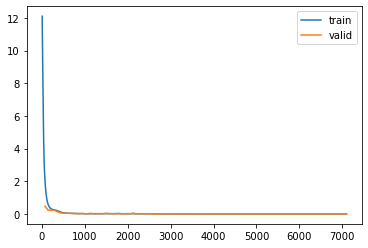

In [28]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [29]:
learn.validate()

(#1) [7.196255864982959e-06]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [30]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [32]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
#     df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

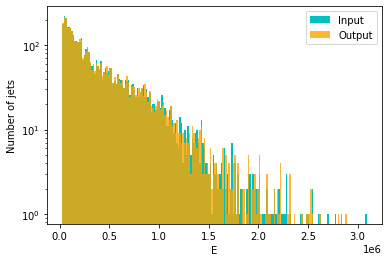

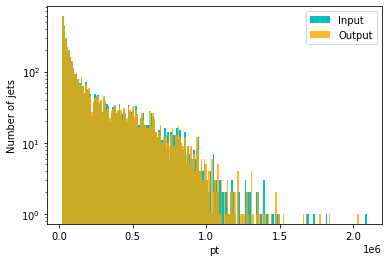

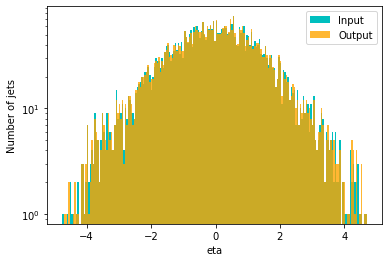

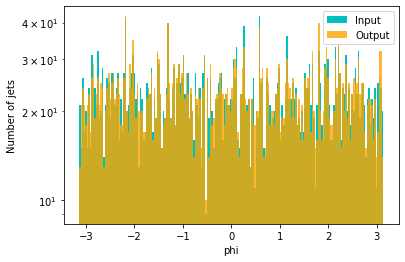

In [81]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 4533)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalizedpred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    
    #plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of jets')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

E:
0.28720369911300303
pt:
0.20563851038282943
eta:
0.16994407418421492
phi:
0.1083710270566394


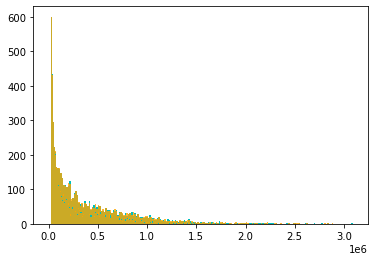

In [105]:
#Calculating mean relative reconstruction error for each compressed variable
def getError(bin1,bin2):
    bins = []
    sum=0
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b1==0:
            bins.append(None)
        else:
            if float(b2)>float(b1):
                bins.append((float(b2)-float(b1))/b1)
                sum=sum+(float(b2)-float(b1))/b1
            else:
                bins.append((float(b1)-float(b2))/b1)
                sum=sum+(float(b1)-float(b2))/b1
    avg=sum/200
    return avg   


n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df['E'].to_list(), color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(unnormalized_pred_df['E'].to_list(), color=colors[0], label='Output', alpha=alph, bins=bin_edges)
rat = getError(n_hist_data,n_hist_pred)
print("E:")
print(rat)

n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df['pt'].to_list(), color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(unnormalized_pred_df['pt'].to_list(), color=colors[0], label='Output', alpha=alph, bins=bin_edges)
rat = getError(n_hist_data,n_hist_pred)
print("pt:")
print(rat)

n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df['eta'].to_list(), color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(unnormalized_pred_df['eta'].to_list(), color=colors[0], label='Output', alpha=alph, bins=bin_edges)
rat = getError(n_hist_data,n_hist_pred)
print("eta:")
print(rat)

n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df['phi'].to_list(), color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(unnormalized_pred_df['phi'].to_list(), color=colors[0], label='Output', alpha=alph, bins=bin_edges)
rat = getError(n_hist_data,n_hist_pred)
print("phi:")
print(rat)